In [ ]:
!pip install pydub

#### **API 키 설정**

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = "YOUR_OPENAI_API_KEY"
os.environ['TAVILY_API_KEY'] = "YOUR_TAVILY_API_KEY"

#### **웹 검색과 스크래핑 도구 설정**

In [31]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'\n{doc.page_content}\n'
            for doc in docs
        ]
    )

#### **OpenAI의 TTS API를 통한 TTS 도구 설정**

In [16]:
from langchain_core.tools import tool
from openai import OpenAI
from pathlib import Path

@tool
def text_to_speech(text: str, voice: str, output_filename: str) -> str:
    """
    Converts text to speech using OpenAI's TTS API, saving the audio file locally with a dynamic filename.

    Args:
        text (str): The text to convert to speech.
        voice (str): The voice model to use for speech synthesis. Options include:
                     - 'alloy', 'echo', 'fable', 'onyx', 'nova', 'shimmer'.
        output_filename (str): The name for the output audio file, including file extension (e.g., 'output.mp3').

    Returns:
        str: The path to the saved audio file.
    """
    client = OpenAI()
    speech_file_path = Path(output_filename)
    response = client.audio.speech.create(model="tts-1-hd", voice=voice, input=text)
    response.stream_to_file(speech_file_path)
    return str(speech_file_path)


#### **주어진 여러 Segment별 오디오 트랙을 하나의 오디오 파일로 만드는 도구 설정**

In [33]:
from langchain_core.tools import tool
from pydub import AudioSegment
from typing import List

@tool
def edit_podcast_audio(segments: List[str], pauses_between_segments: int = 100, output_filename: str = "final_podcast_episode.mp3") -> str:
    """
    Edits a podcast episode by combining audio segments with specified pauses between them, ensuring consistent volume.

    Args:
        segments (List[str]): List of paths to audio segment files.
        pauses_between_segments (int): Duration of pause between segments in milliseconds. Default is 1000.
        output_filename (str): The name for the output podcast file, including file extension (e.g., 'episode.mp3').

    Returns:
        str: The path to the saved podcast episode.
    """
    podcast_episode = AudioSegment.silent(duration=0)  # Initialize an empty audio segment

    for segment_path in segments:
        segment = AudioSegment.from_file(segment_path)  # Load the segment
        podcast_episode += AudioSegment.silent(duration=pauses_between_segments) + segment  # Append with pause

    podcast_episode = podcast_episode.normalize()  # Normalize volume
    podcast_episode.export(output_filename, format='mp3')  # Export the edited podcast

    return output_filename


#### **도구 리스트 정의**

In [35]:
# Define the tools we want to use
tools = [
    tavily_tool,  # Built-in search tool via Tavily
    scrape_webpages,
    text_to_speech,  # Our custom text to speech tool
    edit_podcast_audio # Audio Mix Tool
]


#### **하위 에이전트와 Supervisor 에이전트 설정 함수 정의**

In [37]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

#### **Research Team 구성하기**

In [39]:
import functools
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o-mini")

search_system = """
You are a search specialist in a research team. 
Your role is to use the Tavily search tool to find relevant and up-to-date information on the given topic to generate the podcast.

Your tasks:
1. Analyze the user's request or question.
2. Formulate effective search queries based on the request.
3. Use the Tavily search tool to find information.
4. Summarize the most relevant findings concisely.
5. If the search results are insufficient, consider refining your search query and trying again.

Always strive for accuracy and relevance in your search results. 
If you can't find satisfactory information, be honest about the limitations of your search.
"""

search_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=search_system)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

webscraper_system = """
You are a web scraping specialist in a research team. 
Your role is to extract detailed information from specific web pages using the scrape_webpages tool.

Your tasks:
1. Analyze the URLs or web pages provided, usually as a result of the Search agent's findings.
2. Use the scrape_webpages tool to extract relevant content from these pages.
3. Process and summarize the scraped content, focusing on the most pertinent information related to the research topic.
4. If the scraped content is not satisfactory, consider requesting different URLs from the Search agent or suggesting refinements to the search query.

Ensure that you respect website terms of service and ethical scraping practices. Always summarize and contextualize the information you scrape, don't just return raw data.
"""

research_agent = create_react_agent(llm, tools=[scrape_webpages], state_modifier=webscraper_system)
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

#### **Research Team 그래프 구축 및 상위 레이어와의 연결 Chain 정의**

In [41]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

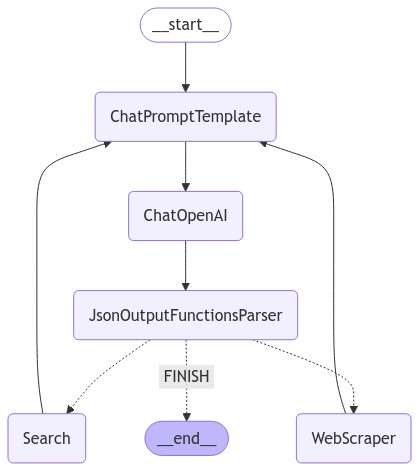

In [43]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

#### **Podcast Team 정의**

In [45]:
# PodcastTeam 그래프 상태
class PodcastTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str
    script: List[dict]
    audio_segments: List[str]

podcast_plan_system="""
You are tasked with creating a structured script for a podcast episode. 
The script should consist of a series of interactions between the host and the guest based on the provided topic and information from the research.
IMPORTANT NOTE: The podcast should have 2 or more speakers to have a conversation.

For each part of the dialogue, clearly specify whether it's the host speaking or the guest. Also, assign a suitable voice model for text-to-speech conversion for each segment. Use the following voice models based on the character:

- Host segments: Use the 'alloy' voice model.
- Guest segments: Use the 'fable' voice model.

The output should be a list where each item is a dictionary with keys 'speaker', 'text', and 'voice', indicating the speaker (host or guest), their line of dialogue, and the voice model to use.

Example output format:
[
    {"speaker": "host", "text": "Welcome to our podcast, where we explore the latest in technology.", "voice": "alloy"},
    {"speaker": "guest", "text": "Thank you for having me, it's great to be here to share my experiences.", "voice": "fable"},
    {"speaker": "host", "text": "Can you tell us about your current project?", "voice": "alloy"},
    {"speaker": "guest", "text": "Certainly! I've been working on a new AI platform that...", "voice": "fable"},
    ...
]

Your task is to generate a similar structured script in **KOREAN**,
ensuring each dialogue segment between the host and guest is well-defined and allocates the appropriate voice model for the text-to-speech conversion process.

"""
podcast_planner_agent = create_react_agent(
    llm, state_modifier=podcast_plan_system,tools=[tavily_tool]
)
podcast_planner_node = functools.partial(agent_node, agent=podcast_planner_agent, name="PodcastPlanner")

# AudioProducer 에이전트
audio_producer_system="""
You are responsible for producing the final audio for the podcast episode. 
Take the structured script provided by the Podcast Planner, which contains segments marked with 'speaker' (either 'host' or 'guest'), the 'text' for each segment, and the 'voice' model to use.

For each segment, use the 'text_to_speech' tool to generate audio, specifying the 'text' and 'voice' as provided. 
Ensure each segment is saved as a separate audio file.

After generating all segments, use the 'edit_podcast_audio' tool to combine these audio files into one seamless podcast episode. 
The audio files should be combined in the order they are provided in the script, with appropriate pauses between segments to simulate a natural conversation flow.

Your output should be the path to the final combined podcast episode audio file.
"""
audio_producer_agent = create_react_agent(
    llm,
    [text_to_speech, edit_podcast_audio], state_modifier=audio_producer_system
)
audio_producer_node = functools.partial(agent_node, agent=audio_producer_agent, name="AudioProducer")

# 팀 감독자 생성
podcast_supervisor = create_team_supervisor(
    llm,
    """You are a supervisor tasked with managing the podcast creation process.
    Your team consists of a PodcastPlanner and an AudioProducer.
    Given the current state, decide which team member should act next or if the process is complete.
    Respond with 'PodcastPlanner', 'AudioProducer', or 'FINISH'.""",
    ["PodcastPlanner", "AudioProducer"]
)

#### **Podcast Team 그래프 및 상위 레이어와의 연결 Chain 정의**

In [47]:
podcast_graph = StateGraph(PodcastTeamState)
podcast_graph.add_node("PodcastPlanner", podcast_planner_node)
podcast_graph.add_node("AudioProducer", audio_producer_node)
podcast_graph.add_node("supervisor", podcast_supervisor)

# 제어 흐름 정의
podcast_graph.add_edge("PodcastPlanner", "supervisor")
podcast_graph.add_edge("AudioProducer", "supervisor")
podcast_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"PodcastPlanner": "PodcastPlanner", "AudioProducer": "AudioProducer", "FINISH": END},
)
podcast_graph.add_edge(START, "supervisor")

chain = podcast_graph.compile()

# 상위 레벨 그래프 상태와 팟캐스트 서브그래프 상태 간의 상호 운용을 위한 함수
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["PodcastPlanner", "AudioProducer"],
        "next": "",
        "script": [],
        "audio_segments": []
    }
    return results

podcast_chain = enter_chain | chain

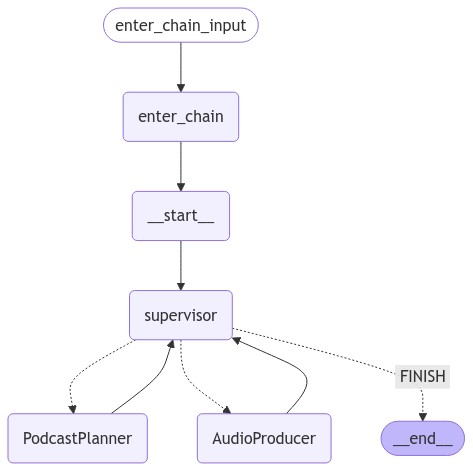

In [49]:
from IPython.display import Image, display

display(Image(podcast_chain.get_graph().draw_mermaid_png()))

#### **상위 레이어의 Supervisor 정의하기**

In [51]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PodcastTeam"],
)

#### **상위 레이어 그래프 구축하기**

In [53]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PodcastTeam", get_last_message | podcast_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PodcastTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PodcastTeam": "PodcastTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

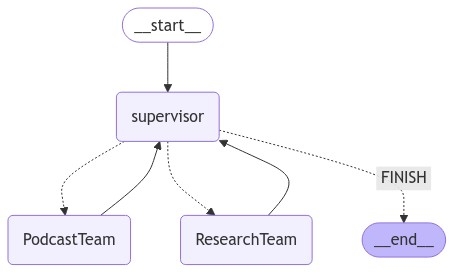

In [55]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [57]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="OpenAI가 최근에 출시한 o1 모델과 AI 에이전트"
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='### OpenAI o1 Model Release\n\nOpenAI has recently released its new model, known as **o1** (code-named "Strawberry"), which is designed to enhance reasoning capabilities in AI. Here are the key points regarding this release:\n\n1. **Reasoning Capabilities**: The o1 model is the first in a series of models that emphasize reasoning. It can handle more complex tasks in areas such as science, coding, and math, outperforming previous models like GPT-4o. This model is designed to "think" before responding, allowing it to fact-check itself and provide more accurate answers. \n\n2. **Performance**: Early testing has shown that the o1 model can solve multi-step problems and is positioned to reach human-like intelligence levels in specific tasks. Notably, it achieved a high percentile in online programming challenges.\n\n3. **User Experience**: The model aims to provide users with the ability to int

C:\Users\user\AppData\Local\Temp\ipykernel_15856\1764095847.py:22: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
C:\Users\user\AppData\Local\Temp\ipykernel_15856\1764095847.py:22: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
C:\Users\user\AppData\Local\Temp\ipykernel_15856\1764095847.py:22: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
C:\Users\user\AppData\Local\Temp\ipykernel_15856\1764095847.py:22: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used inst

{'PodcastTeam': {'messages': [HumanMessage(content='The final combined podcast episode audio file has been created successfully. You can find it at the following path: **final_podcast_episode.mp3**.', additional_kwargs={}, response_metadata={}, name='AudioProducer')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [78]:
super_graph.get_state

<bound method Pregel.get_state of <langgraph.graph.state.CompiledStateGraph object at 0x000001A6B33E7CD0>>